In [ ]:
import import_ipynb
from data603 import HDFS

httpdfs = HDFS.get_httpdfs()
httpdfs.list('/data/keras_models')

importing Jupyter notebook from /scratch/data603/yk98337/data603/HDFS.ipynb


['densenet',
 'efficientnet',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'vgg16',
 'vgg19',
 'xception']

# Predicting the accuracy of model for different labels
We took MobileNet as our pre-trained model because they have reduced size of the network which makes them to run faster on image datasets.

In [ ]:
import import_ipynb
from data603 import SparkLauncher

# get a configuration object
conf = SparkLauncher.get_spark_conf()

# add a file to the configuration that will get copied to all the nodes on the cluster
conf.set('spark.yarn.dist.files', './keras_data/mobilenet_1_0_224_tf.h5')

# launch the cluster using the configuration
spark = SparkLauncher.get_spark_session(pack_venv = False, conf = conf)

importing Jupyter notebook from /scratch/data603/yk98337/data603/SparkLauncher.ipynb
Creating Spark Configuration
Creating Spark Configuration
Setting Environment Variables
Creating Spark Session: yk98337_data603_spark_session


In [ ]:
cats = spark.read.parquet('/user/yk98337/land_mammals.parquet')

In [ ]:
cats = cats.where(cats['Label'] == 'Lion')

Loading the model for predictions

In [ ]:
def evaluate_chip(chip_data):
    import io
    import os
    from tensorflow.keras.applications.mobilenet import MobileNet
    from tensorflow.keras.applications.mobilenet import preprocess_input
    from tensorflow.keras.applications.mobilenet import decode_predictions
    from tensorflow.keras.preprocessing.image import load_img
    from tensorflow.keras.preprocessing.image import img_to_array

    # Load the image
    img = load_img(io.BytesIO(chip_data), target_size = (224,224))

    # Prepare Image
    image = img_to_array(img)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Load Model Data
    model = MobileNet(weights = f'{os.getcwd()}/mobilenet_1_0_224_tf.h5',
                 include_top = True,
                 alpha = 1.0)
    
    # Run prediction
    yhat = model.predict(image)

    # Decode Predictions
    label = decode_predictions(yhat)
    label = label[0][0]

    ret = [label[1], float(label[2])]   

    return ret

In [ ]:
# make a UDF
from pyspark.sql.types import *
from pyspark.sql.functions import udf

schema = ArrayType(StringType())

udf_evaluate_chip = udf(evaluate_chip, schema)


from sklearn.metrics import accuracy_score
cat_scores = []
for i in ['Lion','Tiger','Cheetah','Lynx','Leopard']:
    cat = cat.where(cat['Label'] == i).withColumn("prediction", udf_evaluate_chip("chip_data"))
    cat = cat.select('ImageID','Label','chip_data',cat.prediction[0],cat.prediction[1])
    cat = cat.withColumnRenamed('prediction[0]','predicted_label')
    cat = cat.withColumnRenamed('prediction[1]','predicted_score')
    preds = cat.select('predicted_label','Label').toPandas()
    preds['Label'] = preds['Label'].str.lower()
    cat_scores.append(accuracy_score(preds['predicted_label'],preds['Label']))

In [ ]:
# get rid of the original image data
cat = cat.drop('Data')

# evaluate image chips
cats = cats.withColumn("prediction", udf_evaluate_chip("chip_data"))

In [ ]:
cats.select('prediction').show(5)

+--------------------+
|          prediction|
+--------------------+
|[French_bulldog, ...|
|[hen-of-the-woods...|
|[lion, 0.99974662...|
|[lion, 0.50911587...|
|[Siamese_cat, 0.2...|
+--------------------+
only showing top 5 rows



Extracting the accuracy score for each label

In [ ]:
cat = cat.select('ImageID','Label','chip_data',cats.prediction[0],cats.prediction[1])
cat = cat.withColumnRenamed('prediction[0]','predicted_label')
cat = cat.withColumnRenamed('prediction[1]','predicted_score')

In [ ]:
import pyspark.sql.functions as F
cat = cat.withColumn('Label',F.lower(F.col('Label')))

In [ ]:
preds_cat = cat.select('predicted_label','Label').toPandas()

In [ ]:
from sklearn.metrics import accuracy_score
lion_ac = accuracy_score(preds_cat['predicted_label'],preds_cat['Label'])

In [ ]:
lion_ac

0.5683030949839915

In [ ]:
tiger = cats.where(cats['Label'] == 'Tiger')

In [ ]:
tiger = tiger.withColumn("prediction", udf_evaluate_chip("chip_data"))

In [ ]:
tiger = tiger.select('ImageID','Label','chip_data',tiger.prediction[0],tiger.prediction[1])
tiger = tiger.withColumnRenamed('prediction[0]','predicted_label')
tiger = tiger.withColumnRenamed('prediction[1]','predicted_score')

In [ ]:
tiger = tiger.withColumn('Label',F.lower(F.col('Label')))
preds_tiger = tiger.select('predicted_label','Label').toPandas()

In [ ]:
tiger_ac = accuracy_score(preds_tiger['predicted_label'],preds_tiger['Label'])
tiger_ac

0.7672349888806523

In [ ]:
cheetah = cats.where(cats['Label'] == 'Cheetah')

In [ ]:
cheetah = cheetah.withColumn("prediction", udf_evaluate_chip("chip_data"))

In [ ]:
cheetah = cheetah.select('ImageID','Label','chip_data',cheetah.prediction[0],cheetah.prediction[1])
cheetah = cheetah.withColumnRenamed('prediction[0]','predicted_label')
cheetah = cheetah.withColumnRenamed('prediction[1]','predicted_score')

In [ ]:
cheetah = cheetah.withColumn('Label',F.lower(F.col('Label')))
preds_cheetah = cheetah.select('predicted_label','Label').toPandas()

In [ ]:
cheetah_ac = accuracy_score(preds_cheetah['predicted_label'],preds_cheetah['Label'])
cheetah_ac

0.5886524822695035

In [ ]:
leopard = cats.where(cats['Label'] == 'Leopard')

In [ ]:
leopard = leopard.withColumn("prediction", udf_evaluate_chip("chip_data"))

In [ ]:
leopard = leopard.select('ImageID','Label','chip_data',leopard.prediction[0],leopard.prediction[1])
leopard = leopard.withColumnRenamed('prediction[0]','predicted_label')
leopard = leopard.withColumnRenamed('prediction[1]','predicted_score')

In [ ]:
leopard = leopard.withColumn('Label',F.lower(F.col('Label')))
preds_leopard = leopard.select('predicted_label','Label').toPandas()

In [ ]:
leopard_ac = accuracy_score(preds_leopard['predicted_label'],preds_leopard['Label'])
leopard_ac

0.30622489959839355

In [ ]:
lynx = cats.where(cats['Label'] == 'Lynx')

In [ ]:
lynx = lynx.withColumn("prediction", udf_evaluate_chip("chip_data"))

In [ ]:
lynx = lynx.select('ImageID','Label','chip_data',lynx.prediction[0],lynx.prediction[1])
lynx = lynx.withColumnRenamed('prediction[0]','predicted_label')
lynx = lynx.withColumnRenamed('prediction[1]','predicted_score')

In [ ]:
lynx = lynx.withColumn('Label',F.lower(F.col('Label')))
preds_lynx = lynx.select('predicted_label','Label').toPandas()

In [ ]:
lynx_ac = accuracy_score(preds_lynx['predicted_label'],preds_lynx['Label'])
lynx_ac

0.5431754874651811

In [ ]:
scores = [lion_ac,tiger_ac,cheetah_ac,leopard_ac,lynx_ac]
names = ['Lion','Tiger','Cheetah','Leopard','Lynx']

<BarContainer object of 5 artists>

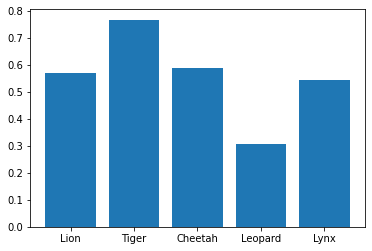

In [ ]:
import matplotlib.pyplot as plt
plt.bar(names,scores)

In [ ]:
scores = [float(i) for i in scores]

In [ ]:
df = spark.createDataFrame(zip(names,scores),schema=['Label','Score'])

In [ ]:
df.show()

+-------+-------------------+
|  Label|              Score|
+-------+-------------------+
|   Lion| 0.5683030949839915|
|  Tiger| 0.7672349888806523|
|Cheetah| 0.5886524822695035|
|Leopard|0.30622489959839355|
|   Lynx| 0.5431754874651811|
+-------+-------------------+



In [ ]:
df.write.parquet('/user/yk98337/cats_accuracy_1.parquet')

In [ ]:
df1 = spark.read.parquet('/user/yk98337/cats_accuracy_1.parquet')
df2 = spark.read.parquet('/user/yk98337/bears_accuracy_1.parquet')
df3 = spark.read.parquet('/user/yk98337/bigan_accuracy_1.parquet')

In [ ]:
df = df1.union(df2).union(df3)

In [ ]:
df = df.toPandas()

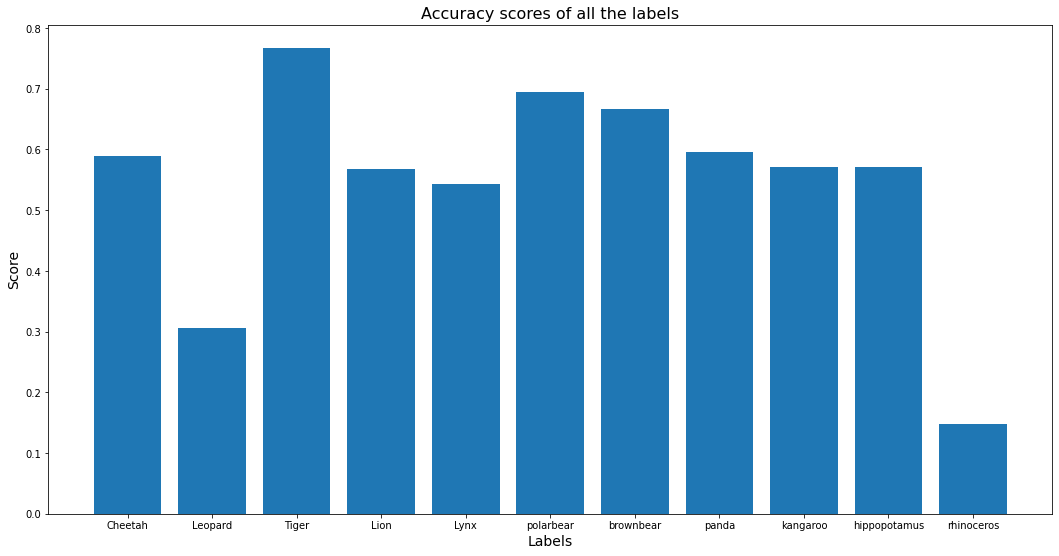

In [ ]:
import matplotlib.pyplot as plt
plt.bar(df['Label'],df['Score'])
fig=plt.gcf()
fig.set_size_inches(18,9)
_=fig=plt.title('Accuracy scores of all the labels',fontsize=16)
_=fig=plt.xlabel('Labels',fontsize=14)
_=fig=plt.ylabel('Score',fontsize=14)